In [86]:
import numpy as np
import pandas as pd

import xgboost

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report, \
recall_score, make_scorer, auc, roc_curve
from sklearn.ensemble import BaggingClassifier

from sklearn.externals import joblib

In [2]:
# https://github.com/bpb27/trump-tweet-archive/tree/master/data/realdonaldtrump
# data gleaned from above on 4/5/17

list_of_dfs = []

for year in range(2009,2018):
    df = pd.read_json('data/realdonaldtrump/%s.json' % year)
    list_of_dfs.append(df)

In [3]:
df = pd.concat(list_of_dfs, axis=0)

In [4]:
df['is_donald'] = df['source'].apply(lambda x: 1 if x == 'Twitter for Android' else 0)

In [5]:
df.is_donald.value_counts()

0    16245
1    14545
Name: is_donald, dtype: int64

In [6]:
df.columns

Index(['created_at', 'favorite_count', 'id_str', 'in_reply_to_user_id_str',
       'is_retweet', 'retweet_count', 'source', 'text', 'is_donald'],
      dtype='object')

In [7]:
df1 = df[df['is_donald'] == 1].copy()
df2 = df[df['is_donald'] == 0].copy()

In [8]:
df1['is_donald'] = df1['text'].apply(lambda x: 0 if x[:2] == "\"@" else 1)

In [9]:
df = pd.concat([df1,df2])

In [10]:
df.shape

(30790, 9)

In [11]:
np.mean(df.is_donald)

0.1517375771354336

In [13]:
df.columns

Index(['created_at', 'favorite_count', 'id_str', 'in_reply_to_user_id_str',
       'is_retweet', 'retweet_count', 'source', 'text', 'is_donald'],
      dtype='object')

In [15]:
cv = CountVectorizer(max_features = 2000, ngram_range=(1,3))

In [16]:
cv_out = cv.fit_transform(df.text.values)


In [25]:
cv.vocabulary_

{'have': 645,
 'happy': 632,
 'successful': 1485,
 'and': 84,
 'new': 1066,
 'year': 1954,
 'new year': 1069,
 'when': 1873,
 'it': 815,
 'comes': 312,
 'to': 1659,
 'money': 1024,
 'even': 463,
 'life': 892,
 'protect': 1260,
 'the': 1542,
 'will': 1895,
 'take': 1496,
 'care': 271,
 'of': 1106,
 'when it': 1875,
 'and the': 98,
 'spend': 1457,
 'your': 1995,
 'last': 866,
 'day': 367,
 '2013': 14,
 'you': 1961,
 'make': 952,
 'in': 734,
 '2014': 15,
 'best': 201,
 'ever': 467,
 'you will': 1992,
 'will make': 1906,
 'to make': 1674,
 'make it': 955,
 'name': 1048,
 'from': 553,
 'global': 580,
 'warming': 1829,
 'climate': 300,
 'change': 286,
 'was': 1830,
 'no': 1080,
 'longer': 913,
 'working': 1938,
 'lost': 928,
 'global warming': 581,
 'what': 1867,
 'hell': 670,
 'is': 784,
 'going': 587,
 'on': 1135,
 'with': 1921,
 'building': 238,
 'are': 120,
 'total': 1713,
 'job': 835,
 'what the': 1871,
 'the hell': 1571,
 'is going': 789,
 'going on': 588,
 'realdonaldtrump': 1287,
 't

In [18]:
tfidf = TfidfVectorizer(max_features = 2000, ngram_range=(1,3))

In [19]:
tfidf_vector = tfidf.fit_transform(df.text.values)

In [20]:
tfidf_vector

<30790x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 462845 stored elements in Compressed Sparse Row format>

In [71]:
tfidf_vector.todense()

matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [29]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_vector.todense(), df.is_donald.values)

In [30]:
lr = LogisticRegression()
rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=5)
et = ExtraTreesClassifier(min_samples_leaf=2)
gb = GradientBoostingClassifier(max_depth=3, min_samples_leaf=6)
ab = AdaBoostClassifier(n_estimators=10, base_estimator=lr)

In [62]:
lr_params = {
    'penalty':['l1', 'l2'],
    'C':[.01, .1, 1, 10, 100]
}

lr_grid = GridSearchCV(lr, lr_params, verbose=10, cv=3, n_jobs=-1, scoring=make_scorer(recall_score))

In [63]:
lr_grid.fit(tfidf_vector.todense(), df.is_donald.values)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=0.01, penalty=l1 ..............................................
[CV] ............... C=0.01, penalty=l1, score=0.000000, total=   0.8s
[CV] C=0.01, penalty=l1 ..............................................
[CV] ............... C=0.01, penalty=l1, score=0.000000, total=   0.9s


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.4s


[CV] C=0.01, penalty=l1 ..............................................
[CV] ............... C=0.01, penalty=l1, score=0.000000, total=   0.7s
[CV] C=0.01, penalty=l2 ..............................................
[CV] ............... C=0.01, penalty=l2, score=0.000000, total=   0.9s
[CV] C=0.01, penalty=l2 ..............................................
[CV] ............... C=0.01, penalty=l2, score=0.000000, total=   0.7s
[CV] C=0.01, penalty=l2 ..............................................
[CV] ............... C=0.01, penalty=l2, score=0.000000, total=   0.7s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ................ C=0.1, penalty=l1, score=0.023107, total=   0.7s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ................ C=0.1, penalty=l1, score=0.062942, total=   0.7s
[CV] C=0.1, penalty=l1 ...............................................
[CV] ................ C=0.1, penalty=l1, score=0.054592, total=   0.8s


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   38.8s


[CV] C=0.1, penalty=l2 ...............................................
[CV] ................ C=0.1, penalty=l2, score=0.010911, total=   0.5s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................ C=0.1, penalty=l2, score=0.036609, total=   0.7s
[CV] C=0.1, penalty=l2 ...............................................
[CV] ................ C=0.1, penalty=l2, score=0.038536, total=   0.7s
[CV] C=1, penalty=l1 .................................................
[CV] .................. C=1, penalty=l1, score=0.186136, total=   0.9s
[CV] C=1, penalty=l1 .................................................
[CV] .................. C=1, penalty=l1, score=0.499679, total=   0.8s
[CV] C=1, penalty=l1 .................................................
[CV] .................. C=1, penalty=l1, score=0.556840, total=   0.8s
[CV] C=1, penalty=l2 .................................................
[CV] .................. C=1, penalty=l2, score=0.153402, total=   0.8s
[CV] C

[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  1.3min remaining:   46.8s


[CV] C=10, penalty=l1 ................................................
[CV] ................. C=10, penalty=l1, score=0.574181, total=   1.0s
[CV] C=10, penalty=l1 ................................................
[CV] ................. C=10, penalty=l1, score=0.644188, total=   1.0s
[CV] C=10, penalty=l2 ................................................
[CV] ................. C=10, penalty=l2, score=0.244544, total=   0.8s
[CV] C=10, penalty=l2 ................................................
[CV] ................. C=10, penalty=l2, score=0.546564, total=   0.7s


[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.6min remaining:   29.4s


[CV] C=10, penalty=l2 ................................................
[CV] ................. C=10, penalty=l2, score=0.635196, total=   0.8s
[CV] C=100, penalty=l1 ...............................................
[CV] ................ C=100, penalty=l1, score=0.280488, total=   1.4s
[CV] C=100, penalty=l1 ...............................................
[CV] ................ C=100, penalty=l1, score=0.567759, total=   1.3s
[CV] C=100, penalty=l1 ...............................................
[CV] ................ C=100, penalty=l1, score=0.623635, total=   1.1s


[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.9min remaining:   12.8s


[CV] C=100, penalty=l2 ...............................................
[CV] ................ C=100, penalty=l2, score=0.277279, total=   0.8s
[CV] C=100, penalty=l2 ...............................................
[CV] ................ C=100, penalty=l2, score=0.565832, total=   0.7s
[CV] C=100, penalty=l2 ...............................................
[CV] ................ C=100, penalty=l2, score=0.627489, total=   0.6s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(recall_score), verbose=10)

In [64]:
lr_grid.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [65]:
run_model(x_train, y_train, x_test, y_test, lr_grid.best_estimator_)

Base model score: 0.1517
Training set score: 0.9324
Test set score: 0.8942

Confusion Matrix:
       predicted_0  predicted_1
is_0         6193          337
is_1          477          691

Classification Report:
              precision    recall  f1-score   support

          0       0.93      0.95      0.94      6530
          1       0.67      0.59      0.63      1168

avg / total       0.89      0.89      0.89      7698



In [106]:
rf_params = {
    'n_estimators':[10,100],
}

rf_grid = GridSearchCV(rf, rf_params, verbose=10, cv=3, n_jobs=-1, scoring=make_scorer(recall_score))

In [107]:
rf_grid.fit(tfidf_vector.todense(), df.is_donald.values)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] n_estimators=10 .................................................
[CV] n_estimators=10 .................................................
[CV] .................. n_estimators=10, score=0.037227, total=   6.5s
[CV] .................. n_estimators=10, score=0.184971, total=   4.7s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   14.5s remaining:   28.9s


[CV] n_estimators=100 ................................................
[CV] .................. n_estimators=10, score=0.208092, total=   5.8s


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   20.6s remaining:   20.6s


[CV] n_estimators=100 ................................................
[CV] n_estimators=100 ................................................
[CV] ................. n_estimators=100, score=0.179833, total=  36.9s


[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  1.0min remaining:   31.3s


[CV] ................. n_estimators=100, score=0.023107, total=  48.4s
[CV] ................. n_estimators=100, score=0.145151, total=  43.8s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True,
       scoring=make_scorer(recall_score), verbose=10)

In [108]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [109]:
run_model(x_train, y_train, x_test, y_test, rf_grid.best_estimator_)

Base model score: 0.1517
Training set score: 0.8935
Test set score: 0.8710
Area under the curve: 0.89900269305

Confusion Matrix:
       predicted_0  predicted_1
is_0         6480           50
is_1          943          225

Classification Report:
              precision    recall  f1-score   support

          0       0.87      0.99      0.93      6530
          1       0.82      0.19      0.31      1168

avg / total       0.86      0.87      0.84      7698



In [66]:
et_params = {
    'min_samples_leaf':[2]
}

et_grid = GridSearchCV(et, et_params, verbose=10, cv=3, n_jobs=-1, scoring=make_scorer(recall_score))

In [67]:
et_grid.fit(tfidf_vector.todense(), df.is_donald.values)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] min_samples_leaf=2 ..............................................
[CV] min_samples_leaf=2 ..............................................
[CV] min_samples_leaf=2 ..............................................
[CV] ............... min_samples_leaf=2, score=0.059692, total=  13.8s
[CV] ............... min_samples_leaf=2, score=0.250482, total=  11.7s
[CV] ............... min_samples_leaf=2, score=0.217084, total=  12.9s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.0s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_leaf': [2]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True,
       scoring=make_scorer(recall_score), verbose=10)

In [68]:
et_grid.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [69]:
run_model(x_train, y_train, x_test, y_test, et_grid.best_estimator_)

Base model score: 0.1517
Training set score: 0.9508
Test set score: 0.8768

Confusion Matrix:
       predicted_0  predicted_1
is_0         6447           83
is_1          865          303

Classification Report:
              precision    recall  f1-score   support

          0       0.88      0.99      0.93      6530
          1       0.78      0.26      0.39      1168

avg / total       0.87      0.88      0.85      7698



In [97]:
def run_model(x_train, y_train, x_test, y_test, model):
    model.fit(x_train, y_train)
    print ("Base model score: " + str(np.mean(y_test))[:6])
    print ("Training set score: " + str(model.score(x_train, y_train))[:6])
    print ("Test set score: " + str(model.score(x_test, y_test))[:6])
    predictions = model.predict(x_test)
    
    y_score = model.predict_proba(x_test)
    fpr, tpr, threshold = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    
    print('Area under the curve: %s' % roc_auc)
    print ("\nConfusion Matrix:\n", pd.DataFrame(confusion_matrix(y_test, predictions), 
                                              columns=['predicted_0', 'predicted_1'], index=['is_0', 'is_1']))
    print ("\nClassification Report:\n",classification_report(y_test, predictions))

In [100]:
def run_model_2(x_train, y_train, x_test, y_test, model, threshold):
    model.fit(x_train, y_train)
    print ("Base model score: " + str(np.mean(y_test))[:6])
    print ("Training set score: " + str(model.score(x_train, y_train))[:6])
    print ("Test set score: " + str(model.score(x_test, y_test))[:6])
    predictions = model.predict_proba(x_test)
    predictions = [1 if x[1] > threshold else 0 for x in predictions]
    
    y_score = model.predict_proba(x_test)
    fpr, tpr, threshold = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    
    print('Area under the curve: %s' % roc_auc)
    print ("\nConfusion Matrix:\n", pd.DataFrame(confusion_matrix(y_test, predictions), 
                                              columns=['predicted_0', 'predicted_1'], index=['is_0', 'is_1']))
    print ("\nClassification Report:\n",classification_report(y_test, predictions))

In [75]:
model_names = ['xgb', 'lr', 'rf', 'et', 'gb', 'ab']

In [76]:
models = [lr, rf, et]

### xgb, gb, ab


for model in models:
    print ("Model: ", str(model).split("(")[0])
    print ("Hyperparameters: " + str(model)[len(str(model).split("(")[0])+1:-1])
    run_model(x_train, y_train, x_test, y_test, model)
    print ("\n")

Model:  XGBClassifier
Hyperparameters: base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1
Base model score: 0.1509
Training set score: 0.8665
Test set score: 0.8665

Confusion Matrix:
       predicted_0  predicted_1
is_0         6488           35
is_1          990          170

Classification Report:
              precision    recall  f1-score   support

          0       0.87      0.99      0.93      6523
          1       0.83      0.15      0.25      1160

avg / total       0.86      0.87      0.82      7683



Model:  LogisticRegression
Hyperparameters: C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=N

//anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
fo = open('data/test_text.txt', 'r')

In [ ]:
fo.name

In [ ]:
test_list = fo.readlines()
test_list

In [ ]:
final_list = []

for x in test_list:
    final_list.append(x.strip())
    
final_list
    

In [ ]:
fo.close()

In [ ]:
test_array = np.array(final_list)
test_array

In [ ]:
test_array.shape

In [ ]:
test_vector = tfidf.transform(test_array)

In [ ]:
np.mean(xgb.predict(test_vector))

In [ ]:
predictions = xgb.predict(test_vector)
predict_proba = xgb.predict_proba(test_vector)

for x, y in zip(test_array, predict_proba):
    if y[1] > 0.85:
        print(x, y[1], '\n')

In [82]:
estimators = list(zip(model_names, models))
estimators

[('xgb', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
         gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
         min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
         objective='binary:logistic', reg_alpha=0, reg_lambda=1,
         scale_pos_weight=1, seed=0, silent=True, subsample=1)),
 ('lr',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)),
 ('rf',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=5,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
     

In [103]:
vc = VotingClassifier([('lr',lr_grid.best_estimator_), 
                       ('rf',rf_grid.best_estimator_), 
                       ('et',et_grid.best_estimator_)], 
                      voting='soft', 
                      n_jobs=-1,
                     weights=[.7,.15,.15])

In [104]:
run_model(x_train, y_train, x_test, y_test, vc)

Base model score: 0.1517
Training set score: 0.9385
Test set score: 0.8981
Area under the curve: 0.932260549309

Confusion Matrix:
       predicted_0  predicted_1
is_0         6268          262
is_1          522          646

Classification Report:
              precision    recall  f1-score   support

          0       0.92      0.96      0.94      6530
          1       0.71      0.55      0.62      1168

avg / total       0.89      0.90      0.89      7698



In [102]:
run_model_2(x_train, y_train, x_test, y_test, vc, .3)

Base model score: 0.1517
Training set score: 0.9398
Test set score: 0.8971
Area under the curve: 0.932295294111

Confusion Matrix:
       predicted_0  predicted_1
is_0         6017          513
is_1          327          841

Classification Report:
              precision    recall  f1-score   support

          0       0.95      0.92      0.93      6530
          1       0.62      0.72      0.67      1168

avg / total       0.90      0.89      0.89      7698



In [79]:
vc.predict_proba(x_train[:10])

array([[ 0.81215685,  0.18784315],
       [ 0.94626694,  0.05373306],
       [ 0.99356533,  0.00643467],
       [ 0.88447081,  0.11552919],
       [ 0.72407229,  0.27592771],
       [ 0.94722238,  0.05277762],
       [ 0.49827431,  0.50172569],
       [ 0.94861169,  0.05138831],
       [ 0.93017674,  0.06982326],
       [ 0.87334954,  0.12665046]])

In [81]:
rf_grid.best_estimator_.decision_path(x_train[1])

(<1x10484 sparse matrix of type '<class 'numpy.int64'>'
 	with 380 stored elements in Compressed Sparse Row format>,
 array([    0,  1057,  2060,  3233,  4386,  5433,  6412,  7437,  8472,
         9469, 10484]))

In [110]:
joblib.dump(lr, 'lr_model.pkl')

['lr_model.pkl']

In [111]:
joblib.dump(tfidf, 'tfidf.pkl')

['tfidf.pkl']

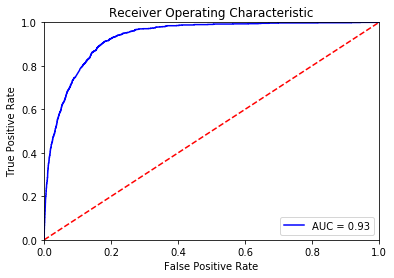

In [105]:
# calculate the fpr and tpr for all thresholds of the classification
probs = vc.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [90]:
run_model(x_train, y_train, x_test, y_test, vc)

Base model score: 0.1517
Training set score: 0.9397
Test set score: 0.8962
Area under the curve: 0.930775307328

Confusion Matrix:
       predicted_0  predicted_1
is_0         6424          106
is_1          693          475

Classification Report:
              precision    recall  f1-score   support

          0       0.90      0.98      0.94      6530
          1       0.82      0.41      0.54      1168

avg / total       0.89      0.90      0.88      7698



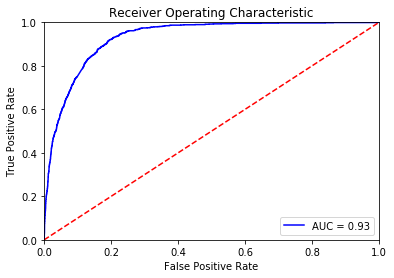

In [91]:
# calculate the fpr and tpr for all thresholds of the classification
probs = lr_grid.best_estimator_.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

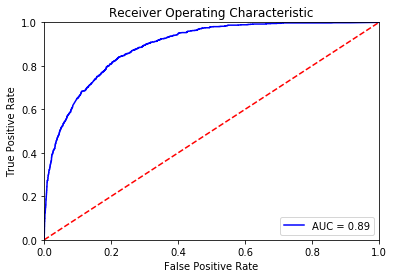

In [92]:
# calculate the fpr and tpr for all thresholds of the classification
probs = rf_grid.best_estimator_.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()